In [2]:
from psa_utils import tap
import pyvo as vo
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import IPython.display as display
from PIL import Image
import pds4_tools
import pdr

t = tap.PsaTap()

# Intro to EPN-TAP

TAP uses ADQL, a SQL-like language to run searches. Let's try some basic queries:

What missions do we have public data in PSA for?

In [2]:
t.query('SELECT DISTINCT instrument_host_name FROM psa.epn_core')

,instrument_host_name
0,SMART-1
1,Hubble
2,Giotto
3,Ground Based
4,BepiColombo
5,Venus Express
6,Huygens
7,Mars Express
8,Chandrayaan-1
9,ExoMars 2016


And how many instruments are supported?

In [3]:
t.query('SELECT COUNT(DISTINCT instrument_name) FROM epn_core')

,COUNT
0,91


What is the breakdown of products per mission?

In [4]:
t.query("""
    SELECT instrument_host_name, count(*) as num_prod 
    FROM epn_core 
    GROUP BY instrument_host_name 
    ORDER BY num_prod DESC
    """)

,instrument_host_name,num_prod
0,ExoMars 2016,23318756
1,Rosetta,7388074
2,Mars Express,1614428
3,SMART-1,604527
4,Venus Express,604373
5,BepiColombo,158034
6,Chandrayaan-1,20345
7,Huygens,13995
8,Giotto,2129
9,Ground Based,2083


And the breakdown by total archive size?

In [5]:
t.query("""
    SELECT instrument_host_name, sum(access_estsize)/1024./1024. as prod_size 
    FROM epn_core 
    WHERE access_estsize IS NOT NULL 
    GROUP BY instrument_host_name 
    ORDER BY prod_size DESC
    """)

,instrument_host_name,prod_size
0,ExoMars 2016,51856.684991
1,Rosetta,51473.643574
2,Mars Express,38798.596021
3,Venus Express,5124.302286
4,SMART-1,434.483055
5,Chandrayaan-1,322.819281
6,Ground Based,71.464685
7,BepiColombo,61.234401
8,JUICE,6.779083
9,Huygens,6.176440


# Drilling into the data

Which instruments have observed Mars?

In [6]:
t.query("SELECT DISTINCT instrument_name FROM psa.epn_core WHERE target_name='Mars'")

,instrument_name
0,OSIRIS
1,ACS
2,CaSSIS
3,NAVCAM
4,RSI
5,RPC
6,ALICE
7,SESAME
8,NOMAD
9,COSAC


Let's look at those NAVCAM data...

In [7]:
result = t.query("SELECT top 1 * FROM psa.epn_core WHERE target_name='Mars' and instrument_name='NAVCAM'")

In [8]:
result.T

,0
access_estsize,2071
access_format,application/x-pds-zip
access_url,https://archives.esac.esa.int/psa/pdap/downloa...
c1max,135.795819
c1min,-124.884818
c2max,53.574039
c2min,-52.469715
creation_date,2016-12-28T16:06:37.101
dataproduct_type,ci
granule_gid,RO-M/CAL-NAVCAM-2-MARS-V1.1:DATA


The `thumbnail_url` gives the snapshots images of the data

In [9]:
url = result.thumbnail_url.squeeze()
url

'https://archives.esac.esa.int/psa/pdap/fileaccess?ID=INTERNATIONALsROSETTAsMISSION/RO-M-CAL-NAVCAM-2-MARS-V1.1/BROWSE/CAM1/ROS_CAM1_20070224T180532.JPG'

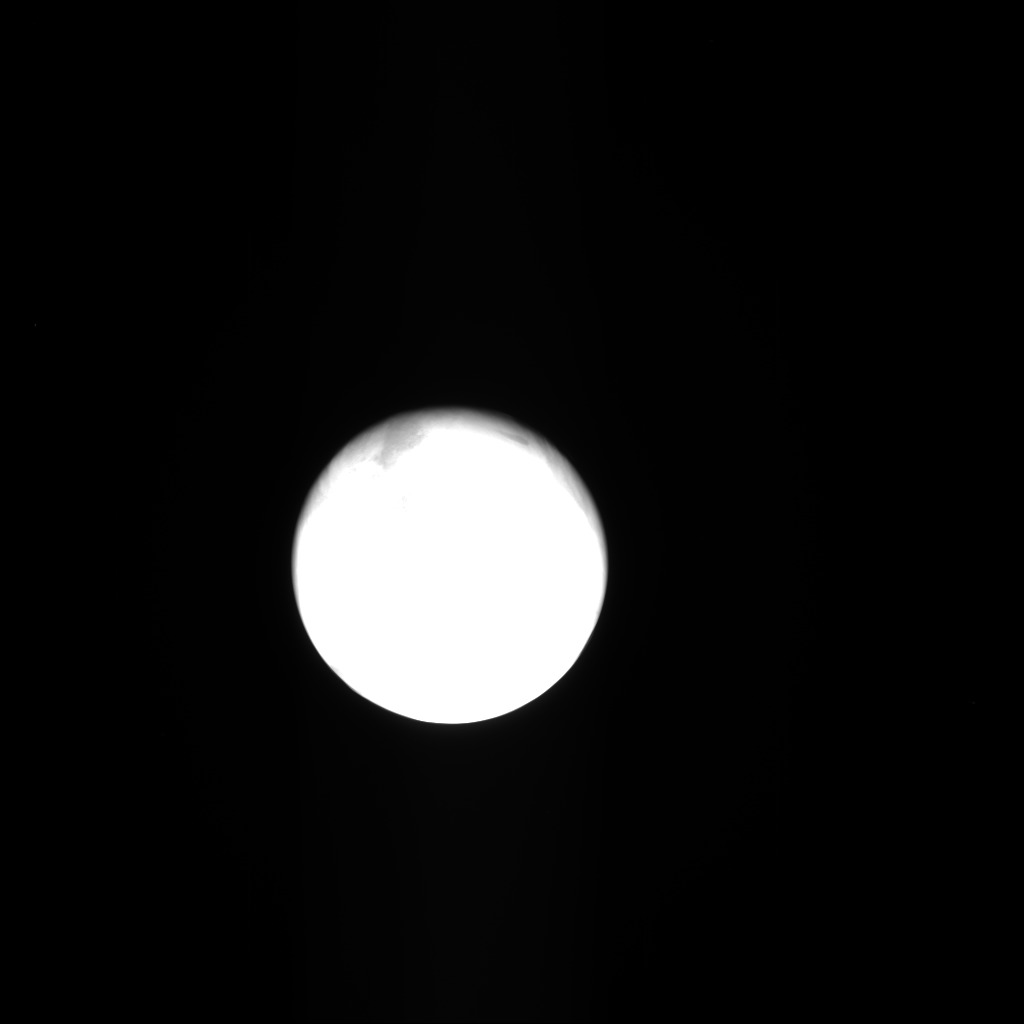

In [10]:
display.Image(url, width=500, embed=True)

## Retrieving PDS4 data

In [11]:
result = t.query("SELECT top 1 * FROM psa.epn_core WHERE instrument_name='MCAM'")

In [12]:
result

,access_estsize,access_format,access_url,creation_date,dataproduct_type,granule_gid,granule_uid,instrument_host_name,instrument_name,instrument_type,...,processing_level,release_date,service_title,spatial_frame_type,s_region,target_class,target_name,thumbnail_url,time_max,time_min
0,2069,application/x-pds-zip,https://archives.esac.esa.int/psa/pdap/downloa...,2024-06-27T00:00:00.0,ci,urn:esa:psa:bc_mtm_mcam:data_raw,urn:esa:psa:bc_mtm_mcam:data_raw:cam_raw_sc_ca...,BepiColombo,MCAM,,...,2,2023-06-22T00:00:00.0,psa,none,,,,https://archives.esac.esa.int/psa/pdap/fileacc...,2018-10-20 17:06:32.437997458,2018-10-20 17:06:32.338018117


In [13]:
struct = pds4_tools.read(result.label_url.iloc[0])

Processing label: https://archives.esac.esa.int/psa/ftp/BepiColombo/bc_mtm_mcam/data_raw/near_earth_commissioning/201810/cam_raw_sc_cam1_image_20181020t170632_01_f__a0100.xml
Now processing a Header structure: FITS primary header
100% [==================================================] (2.11 / 2.11 MB)
Now processing a Header structure: FITS extension header
Now processing a Array_2D_Image structure: MCAM_image


In [14]:
struct

<StructureList at 0x10414eda0> with:
<HeaderStructure 'FITS primary header' at 0x14bd3af80>
<HeaderStructure 'FITS extension header' at 0x14bd3be20>
<ArrayStructure 'MCAM_image' at 0x14bd3a350>

In [15]:
image = struct['MCAM_image']
image

<ArrayStructure 'MCAM_image' at 0x14bd3a350>

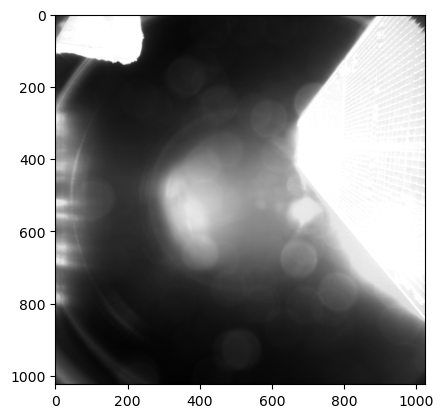

In [16]:
plt.imshow(image.data, plt.cm.gray)

# Geometry search in EPN-TAP

Bounding boxes are also included in EPN-TAP for data proucts providing geometry. We can uses these in queries to geographically limit our search.

In [17]:
start = pd.Timestamp('2021-07-01').to_julian_date()
end = pd.Timestamp('2021-10-31').to_julian_date()

In [18]:
start, end

(2459396.5, 2459518.5)

In [19]:
query = """
    SELECT TOP 3000 granule_uid, time_min, time_max, c1min, c1max, c2min, c2max  
    from psa.epn_core where 
    (c1min >= -143 and c1max <= -125 AND c2min >= 11 AND c2max <= 27) and 
    instrument_name = 'CaSSIS' and
    processing_level=3 and
    granule_uid like '%::3.0' and
    time_min>{:f} and
    time_max<{:f} 
    order by time_min asc
    """.format(start, end)

In [20]:
data = t.query(query)

In [21]:
data.head()

,granule_uid,time_min,time_max,c1min,c1max,c2min,c2max
0,urn:esa:psa:em16_tgo_cas:data_calibrated:cas_c...,2021-07-28 11:22:34.999986288,2021-07-28 11:22:53.000009353,-128.999079,-128.264660,14.919333,15.278702
1,urn:esa:psa:em16_tgo_cas:data_calibrated:cas_c...,2021-07-28 11:22:34.999986288,2021-07-28 11:22:53.000009353,-129.000021,-128.265176,14.891930,15.251875
2,urn:esa:psa:em16_tgo_cas:data_calibrated:cas_c...,2021-07-28 11:22:34.999986288,2021-07-28 11:22:53.000009353,-129.001927,-128.266190,14.836977,15.198116
3,urn:esa:psa:em16_tgo_cas:data_calibrated:cas_c...,2021-07-28 11:22:35.710986256,2021-07-28 11:22:39.711004789,-128.697523,-128.551699,14.971404,14.997584
4,urn:esa:psa:em16_tgo_cas:data_calibrated:cas_c...,2021-07-28 11:22:35.710986256,2021-07-28 11:22:39.711004789,-128.695361,-128.549844,15.053813,15.077946


Recall that:
- c1 = longitude
- c2 = latitude

In [22]:
data['width'] = data.c1max-data.c1min
data['height'] = data.c2max-data.c2min
data = data[data.width>0]

In [23]:
len(data)

1246

In [24]:
def plot_bounding(data, zoom=True, margin=1.0):
    Image.MAX_IMAGE_PIXELS = None
    max_lat =  -90.
    min_lat =  +90.
    max_lon =    -180.
    min_lon = 180.
    fig, ax= plt.subplots(figsize=(14,9))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    # img = plt.imread('/Users/mbentley/Downloads/Mars_MGS_MOLA_ClrShade_merge_global_463m.tif')
    img = plt.imread('/Users/mbentley/Downloads/Mars_MGS_MOLA_ClrShade_merge_global_463m_2.tif')
    ax.imshow(img, zorder=0,  extent=[-180, 180, -90.0, 90.0], alpha=1.0, interpolation='None')
    for idx, row in data.iterrows():
        width = row.c1max-row.c1min
        height = row.c2max-row.c2min
        if width < 0.:
            continue
        min_lat = row.c2min if row.c2min < min_lat else min_lat
        max_lat = row.c2max if row.c2max > max_lat else max_lat
        min_lon = row.c1min if row.c1min < min_lon else min_lon
        max_lon = row.c1max if row.c1max > max_lon else max_lon
        ax.add_patch(Rectangle((row.c1min, row.c2min), width, height, fill=None, alpha=1., color='r'))
    if zoom:
        ax.set_xlim(min_lon-margin, max_lon+margin)
        ax.set_ylim(min_lat-margin, max_lat+margin)

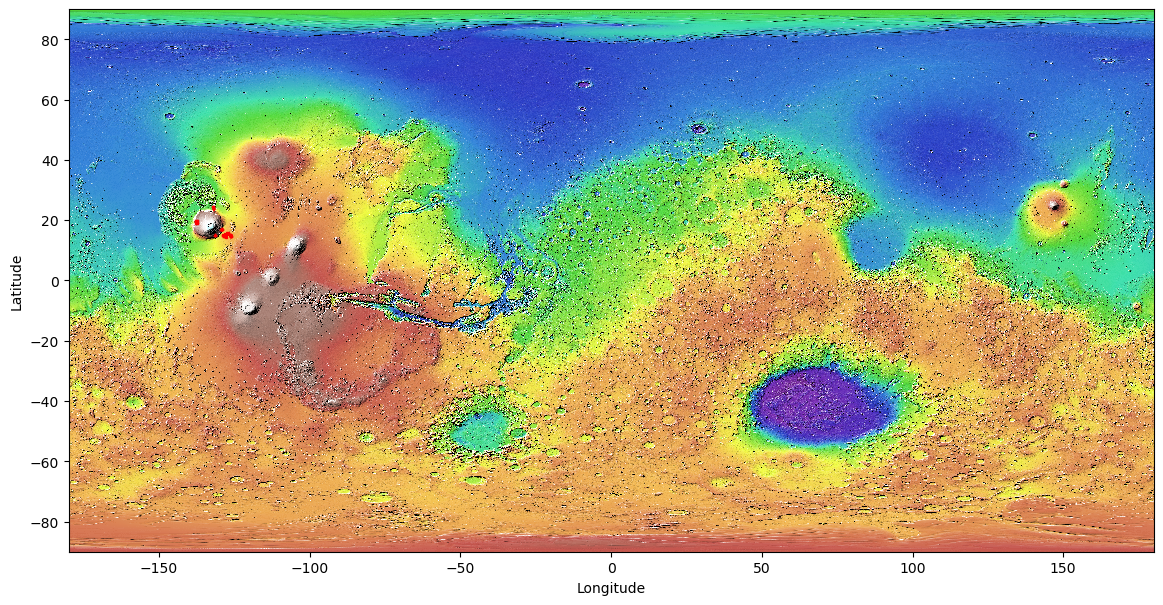

In [25]:
plot_bounding(data, zoom=False)

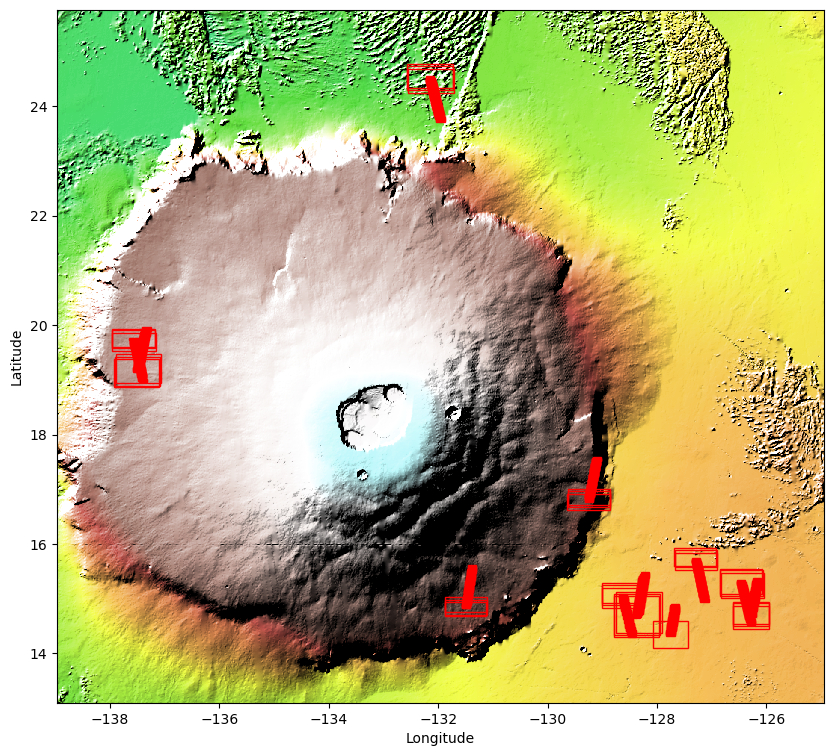

In [26]:
plot_bounding(data, zoom=True)

# Advancecd: using PostGIS functions via TAP

This is not documented ;-) but it is possible to use postGIS functions to the TAP service and get data back....

In [27]:
q = t.query("""
    select top 1 ST_AsGeoJSON(footprint_geometry), ST_AsGeoJSON(Box2D(footprint_geometry)) 
    from psa.product_ui where footprint_geometry is not null
    """)

In [28]:
q.squeeze().iloc[0]

'{"type":"MultiPolygon","coordinates":[[[[180,-4.39354845],[0.094758,-4.391135],[0.202349,-4.386377],[0.309953,-4.38169],[0.417575,-4.377073],[0.525219,-4.372526],[180,4.913227092],[180,-4.39354845]]],[[[180,5.130820886],[179.961876,5.132925],[179.850694,5.139147],[179.739524,5.145454],[179.628359,5.151847],[179.5172,5.158326],[179.406044,5.16489],[179.294886,5.171539],[179.183724,5.178274],[179.072557,5.185094],[178.961383,5.191998],[178.850196,5.198988],[178.738996,5.206063],[178.627782,5.213222],[178.516546,5.220466],[178.405289,5.227795],[178.294009,5.235209],[178.182701,5.242707],[178.071363,5.25029],[177.959993,5.257958],[177.848591,5.265709],[177.73715,5.273545],[177.625668,5.281466],[177.514145,5.289471],[177.402576,5.29756],[177.290958,5.305734],[177.179292,5.313991],[177.067572,5.322333],[176.955795,5.330759],[176.843961,5.339269],[176.732067,5.347862],[176.620108,5.35654],[176.508083,5.365302],[176.39599,5.374147],[176.283824,5.383077],[176.171584,5.392091],[176.059269,5.401

Example of getting footprints of data

In [29]:
q="""
    select top 1000 logical_identifier, start_date_time, instrument_name, ST_AsText(footprint_geometry) as footprint_geometry, 
    ST_AsText(footprint_geometry_nosplit) as footprint_geometry_nosplit
    from psa.product_ui_mex where footprint_geometry is not null and 
    target_name='Mars' AND 
    lastproduct='true' AND 
    instrument_name = 'HRSC' AND
    (ST_Contains(ST_GeomFromText('POLYGON((-30 -30, -30 30, 30 30, 30 -30, -30 -30))',949900),ST_SetSRID(footprint_geometry,949900))='true') AND footprint_srid=949900
    order by start_date_time desc
    """

In [30]:
def query(q, sync=True, dropna=True, verbose=False):
        """Make a simple query and return the data as a pandas DataFrame"""
        
        ops_url = 'https://archives.esac.esa.int/psa-tap/tap'
        tap = vo.dal.TAPService(ops_url)
        
        if sync:
            try:
                data = tap.run_sync(q, maxrec=-1).to_table()
            except ValueError as err:
                log.error('query error: {0}'.format(err))
                return None
            except HTTPError as err:
                log.error('http error: {0}'.format(err))
                return None

            data = data.to_pandas()

            if data.empty:
                log.warn('no results returned')
                return None
            
            # check for byte encoded (object) strings and decode to utf-8
            for col, dtype in data.dtypes.items():
                if dtype == np.object_:
                    # check if we really have bytes here or a string
                    if not isinstance(data[col].iloc[0], str):
                        data[col] = data[col].str.decode('utf-8')
              
        if 'time_min' in data.columns:
            data['time_min'] = pd.to_datetime(data['time_min'], origin='julian', unit='D') 

        if 'time_max' in data.columns:
            data['time_max'] = pd.to_datetime(data['time_max'], origin='julian', unit='D') 

        if dropna:
            data.dropna(inplace=True, axis=1, how='all')

        if len(data) == 2000:
            log.warn('results incomplete due to synchronous query limit - repeat with sync=false')

        return data

In [31]:
rawdata = query(q)